In [53]:
import os
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"

import pandas as pd
import numpy as np
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.utilities.distribution import MultiprocessingDistributor

In [54]:
class Window:
    def __init__(self, targets, window_size=100):
        self.targets = targets
        self.window_size = window_size

        self.start = 0
        self.end = self.window_size


    def get(self):
        return self.targets[self.start: self.end]

    def next(self):
        self.start += 1
        self.end += 1

    def hasNext(self):
        if self.end < len(self.targets):
            return True

        return False

In [55]:
class Building:
    def __init__(self, train_x, train_y, val_x, val_y, test_x):
        self.train_x = train_x
        self.train_y = train_y
        
        self.val_x = val_x
        self.val_y = val_y
        
        self.test_x = test_x
        

In [56]:
class Data:
    
    def __init__(self, train_a, train_b, train_c, observed_a, 
                 observed_b, observed_c, estimated_a, estimated_b, estimated_c, test_a, test_b, test_c):
 
        self.observed_a = self.quartersToHours(observed_a)
        self.observed_b = self.quartersToHours(observed_b)
        self.observed_c = self.quartersToHours(observed_c)
        
        self.estimated_a = self.quartersToHours(estimated_a)
        self.estimated_a = self.estimated_a.drop(["date_calc"], axis=1)
        
        self.estimated_b = self.quartersToHours(estimated_b)
        self.estimated_b = self.estimated_b.drop(["date_calc"], axis=1)
        
        self.estimated_c = self.quartersToHours(estimated_c)
        self.estimated_c = self.estimated_c.drop(["date_calc"], axis=1)

        self.test_a = self.quartersToHours(test_a)
        self.test_a = self.test_a.drop(["date_calc"], axis=1)
        self.test_a = self.test_a.rename(columns={'date_forecast': 'date'})
        
        self.test_b = self.quartersToHours(test_b)
        self.test_b = self.test_b.drop(["date_calc"], axis=1)
        self.test_b = self.test_b.rename(columns={'date_forecast': 'date'})

        self.test_c = self.quartersToHours(test_c)
        self.test_c = self.test_c.drop(["date_calc"], axis=1)
        self.test_c = self.test_c.rename(columns={'date_forecast': 'date'})
        
        
        self.train_a = train_a
        self.train_b = train_b
        self.train_c = train_c
        
        self.data_a = self.join_data(self.observed_a, self.estimated_a, self.train_a)
        self.data_b = self.join_data(self.observed_b, self.estimated_b, self.train_b)
        self.data_c = self.join_data(self.observed_c, self.estimated_c, self.train_c)
        
                
        self.data_a = self.data_a.fillna(0)
        self.test_a = self.test_a.fillna(0)

        self.data_b = self.data_b.fillna(0)
        self.test_b = self.test_b.fillna(0)

        self.data_c = self.data_c.fillna(0)
        self.test_c = self.test_c.fillna(0)
        
        
        
        #extracted_features = extract_features(self.data_a, column_id="id", column_sort="time")

        
        
        self.training_data = [self.data_a, self.data_b, self.data_c]
        self.test_data = [self.test_a, self.test_b, self.test_c]
        
        
        self.process()

    
    
    def join_data(self, observed, estimated, labels):
        #Remove hour and minute values
        observed = observed.assign(date_forecast=observed.date_forecast.dt.round('H'))
        estimated = estimated.assign(date_forecast=estimated.date_forecast.dt.round('H'))

        #rename columns names to match
        observed = observed.rename(columns={'date_forecast': 'date'})
        estimated = estimated.rename(columns={'date_forecast': 'date'})
        labels = labels.rename(columns={'time': 'date'})

        data = pd.concat([observed, estimated])
        joined_data = pd.merge(data, labels, how="inner", on="date")

        return joined_data


    def quartersToHours(self, df):
        df['date_forecast'] = pd.to_datetime(df['date_forecast'], format='%Y-%m.%d %H:%M:%S')
        df["year"] = df['date_forecast'].dt.year
        df["month"] = df['date_forecast'].dt.month
        df["day"] = df['date_forecast'].dt.day
        df["hour"] = df['date_forecast'].dt.hour


        group = df.groupby([df["year"], df["month"], df["day"], df["hour"]])  
        result = group.mean()
        result = result.reset_index()

        return_df = result.drop(['year','month', 'day', 'hour'], axis=1)

        return return_df
    
    def find_and_delete_constants(self, df):
        WINDOW_SIZE = 24

        window = Window(df["pv_measurement"], WINDOW_SIZE)

        constants = []

        while window.hasNext():
            if window.get().std() <= 0.1:
                constants.append((window.start, window.end))
            window.next()

        def extract_indices(ranges):
            return [start for start, _ in ranges]


        indices = extract_indices(constants)


        df = df.drop(indices)
        df = df.reset_index()
        df = df.drop(['index'], axis=1)

        return df
    
    def convert_date_to_sin_and_cos(self, df):
        day = 24*60*60 #seconds in a day
        year = (365.2425)*day #seconds in a year
        month = year / 12.0

        date_time = pd.to_datetime(df['date'], format='%Y-%m.%d %H:%M:%S')

        timestamp_s = date_time.map(pd.Timestamp.timestamp)

        #df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
        #df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))

        df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
        df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

        df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
        df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))
        
        return df
        
    def round_is_day(self, df):
        df["is_day:idx"] = [int(round(df["is_day:idx"][i])) for i in range(len(df))]
        df["is_in_shadow:idx"] = [int(round(df["is_in_shadow:idx"][i])) for i in range(len(df))]
        
        return df
    
    
    def combine_features(self, df):
        
        new_features = [
            [['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W'],
            [['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J']]
        
        for features, new_name in new_features:
    
            totals = []

            for i in range(len(df)):
                total = 0
                for feature in features:
                    total += df[feature][i]

                totals.append(total)
            df[new_name] = totals
            
        return df
    
    def remove_unused_columns(self, df):
        df = df.drop(['snow_drift:idx', 'elevation:m', "rain_water:kgm2", "sun_azimuth:d","rain_water:kgm2",
                      "wind_speed_w_1000hPa:ms"], axis=1)
        return df
    
    def split_data(self, df):
        val_split = 0.2

        len_df = len(df)
        train_len = int(len_df * (1.0 - val_split))

        train = df.iloc[:train_len,:]
        val = df.iloc[train_len:,:]


        train = train.reset_index()
        train = train.drop(['index'], axis=1)

        val = val.reset_index()
        val = val.drop(['index'], axis=1)

        return train, val
    
    def apply(self, data, function):
        for i in range(len(data)):
            data[i] = function(data[i])
    
    def process(self):
        #PV constants
        self.apply(self.training_data, self.find_and_delete_constants)
  
        
        #Time sin and cos
        self.apply(self.training_data, self.convert_date_to_sin_and_cos)
        self.apply(self.test_data, self.convert_date_to_sin_and_cos)
        
        #Round isday and isshadow
        self.apply(self.training_data, self.round_is_day)
        self.apply(self.test_data, self.round_is_day)
        
        #combine
        self.apply(self.training_data, self.combine_features)
        self.apply(self.test_data, self.combine_features)
        
        #fill Nan
        for i in range(len(self.training_data)):
            self.training_data[i] = self.training_data[i].fillna(0)
            
        for i in range(len(self.test_data)):
            self.test_data[i] = self.test_data[i].fillna(0)
        
        #remove unsused
        self.apply(self.training_data, self.remove_unused_columns)
        self.apply(self.test_data, self.remove_unused_columns)
        
        return

        
        train_data_a, val_data_a = self.split_data(self.training_data[0])
        train_data_b, val_data_b = self.split_data(self.training_data[1])
        train_data_c, val_data_c = self.split_data(self.training_data[2])
        
        train_data_a.drop(["date"], axis=1, inplace=True)
        val_data_a.drop(["date"], axis=1, inplace=True)
        self.test_data[0].drop(["date"], axis=1, inplace=True)

        train_data_b.drop(["date"], axis=1, inplace=True)
        val_data_b.drop(["date"], axis=1, inplace=True)
        self.test_data[1].drop(["date"], axis=1, inplace=True)


        train_data_c.drop(["date"], axis=1, inplace=True)
        val_data_c.drop(["date"], axis=1, inplace=True)
        self.test_data[2].drop(["date"], axis=1, inplace=True)
        
        
        train_data_a = train_data_a
        val_data_a = val_data_a
        
        train_data_b = train_data_b
        val_data_b = val_data_b

        train_data_c = train_data_c
        val_data_c = val_data_c
        
        
        train_a_y = train_data_a.pop("pv_measurement")
        val_a_y = val_data_a.pop("pv_measurement")

        train_b_y = train_data_b.pop("pv_measurement")
        val_b_y = val_data_b.pop("pv_measurement")

        train_c_y = train_data_c.pop("pv_measurement")
        val_c_y = val_data_c.pop("pv_measurement")
        
        self.A = Building(train_data_a, train_a_y, val_data_a, val_a_y, self.test_data[0])
        self.B = Building(train_data_b, train_b_y, val_data_b, val_b_y, self.test_data[1])
        self.C = Building(train_data_c, train_c_y, val_data_c, val_c_y, self.test_data[2])


In [57]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

X_train_observed_a = pd.read_parquet('dataset/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('dataset/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('dataset/C/X_train_observed.parquet')

X_train_estimated_a = pd.read_parquet('dataset/A/X_train_estimated.parquet') 
X_train_estimated_b = pd.read_parquet('dataset/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('dataset/C/X_train_estimated.parquet')

X_test_estimated_a = pd.read_parquet('dataset/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('dataset/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('dataset/C/X_test_estimated.parquet')

In [58]:
data = Data(train_a, train_b, train_c, X_train_observed_a, X_train_observed_b, X_train_observed_c,
                      X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_test_estimated_a, 
                      X_test_estimated_b, X_test_estimated_c)

In [60]:
current_data = data.training_data[0]

In [83]:
corr = current_data.corr()

treshold = 0.95

for col in corr:
    for i in range(len(corr)):
        current = corr[col][i]
        if current >= treshold and current != 1.0:
            print(col, corr.columns[i])

absolute_humidity_2m:gm3 dew_point_2m:K
clear_sky_energy_1h:J clear_sky_rad:W
clear_sky_rad:W clear_sky_energy_1h:J
dew_point_2m:K absolute_humidity_2m:gm3
diffuse_rad:W diffuse_rad_1h:J
diffuse_rad_1h:J diffuse_rad:W
direct_rad:W direct_rad_1h:J
direct_rad_1h:J direct_rad:W
msl_pressure:hPa pressure_100m:hPa
msl_pressure:hPa pressure_50m:hPa
msl_pressure:hPa sfc_pressure:hPa
pressure_100m:hPa msl_pressure:hPa
pressure_100m:hPa pressure_50m:hPa
pressure_100m:hPa sfc_pressure:hPa
pressure_50m:hPa msl_pressure:hPa
pressure_50m:hPa pressure_100m:hPa
pressure_50m:hPa sfc_pressure:hPa
sfc_pressure:hPa msl_pressure:hPa
sfc_pressure:hPa pressure_100m:hPa
sfc_pressure:hPa pressure_50m:hPa
global_rad:W global_rad_1h:J
global_rad_1h:J global_rad:W


C:\Users\marti\AppData\Local\Temp\ipykernel_23308\910657897.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current = corr[col][i]


In [84]:
import seaborn as sns

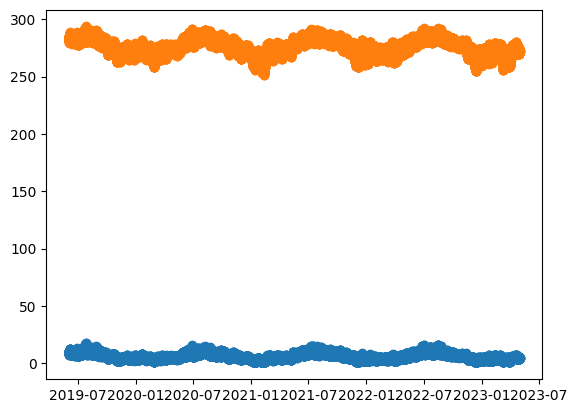

In [100]:
#sns.displot(current_data, x="absolute_humidity_2m:gm3", y="dew_point_2m:K", kind="hist")

plt.scatter(x=current_data["date"], y=current_data["absolute_humidity_2m:gm3"])
plt.scatter(x=current_data["date"], y=current_data["dew_point_2m:K"])